In [168]:
import os, shutil, torch
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    EnsureTyped,
    Orientationd,
    RandFlipd,
    NormalizeIntensityd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    Spacingd,
    MapTransform,
    ToTensord,
    ConcatItemsd
)
from monai.data import Dataset, DataLoader
import nibabel as nib
import numpy as np 
from monai import transforms, data
import matplotlib.pyplot as plt 

class ConvertLabelBasedOnClasses(MapTransform):
    def __call__(self, data):
        d = dict(data)
        # print(data)
        for key in self.keys:
            result = d[key] > 1
            d[key] = result.float()
        return d

class DeleteDataKeysd(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            del d[key]
        return d

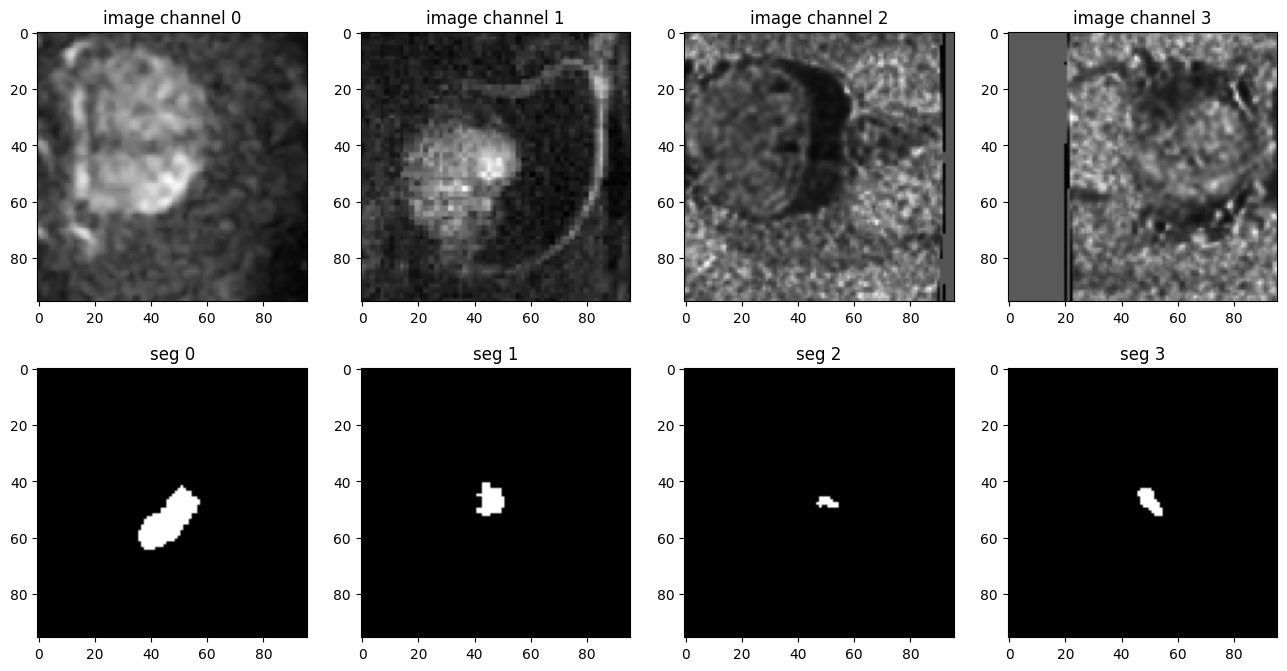

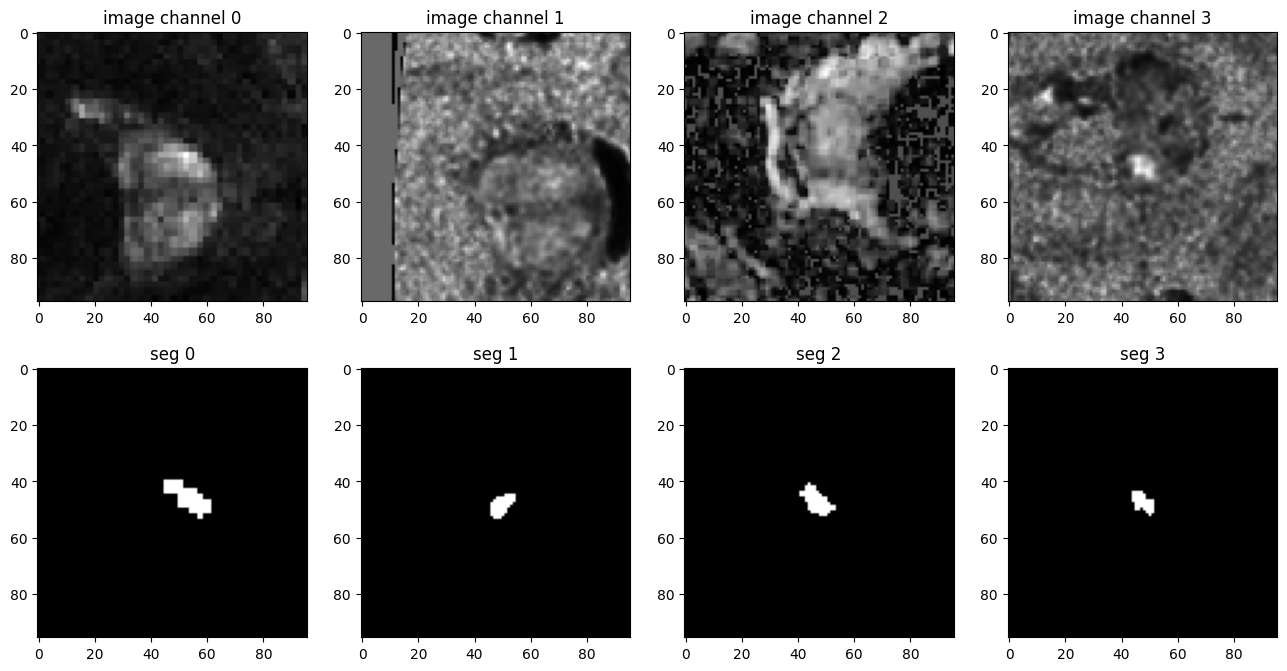

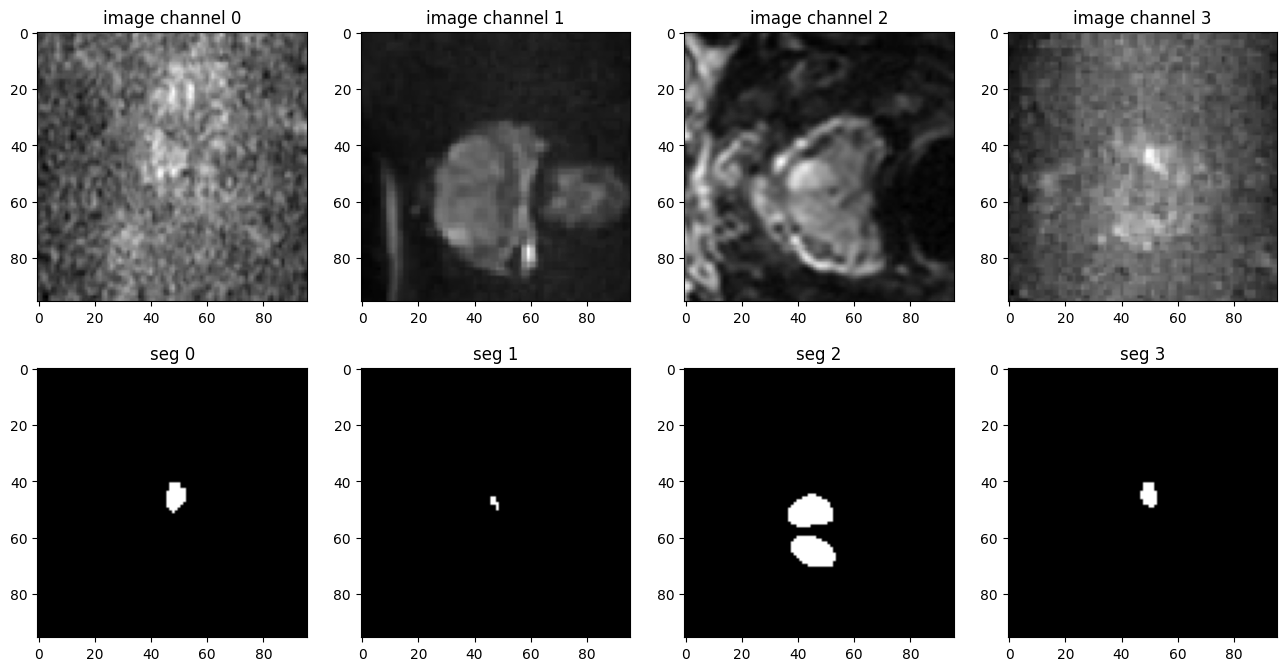

In [182]:
x, y, z = 96, 96, 32
B = 4
modality = 'DWI'
tiantian_root = "/Users/qixinhu/Project/CUHK/Prostate/PAIsData/0426/tiantian"
name_list = os.listdir(tiantian_root)
datalist = []
for name in name_list:
    sample = {"label": os.path.join(tiantian_root, name, f'{name}_{modality}_gt.nii.gz')}
    # for modality in ['T2W', 'DWI', 'ADC']:
    #     sample[modality] = os.path.join(tiantian_root, name, f'{name}_{modality}.nii.gz')
    sample["image"] = os.path.join(tiantian_root, name, f'{name}_{modality}.nii.gz')
    datalist.append(sample)

train_transform = Compose(
    [
        ## load 4 Nifti images and stack them together
        # LoadImaged(keys=["T2W", "DWI", "ADC", "label"]),
        # EnsureTyped(keys=["T2W", "DWI", "ADC", "label"]),
        # ConvertLabelBasedOnClasses(keys="label"),
        # EnsureChannelFirstd(keys=["T2W", "DWI", "ADC", "label"]),
        # ConcatItemsd(keys=["T2W", "DWI", "ADC"], name="image"),
        
        # load single modality
        LoadImaged(keys=["image", "label"]),
        EnsureTyped(keys=["image", "label"]),
        ConvertLabelBasedOnClasses(keys="label"),
        EnsureChannelFirstd(keys=["image", "label"]),

        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        transforms.SpatialPadd(keys=["image", "label"], mode=["minimum", "constant"], spatial_size=[x, y, z]),
        transforms.RandCropByLabelClassesd(
                keys=["image", "label"],
                label_key="label",
                spatial_size=[x, y, z],
                num_classes=2,
                ratios=[0,1],
                num_samples=1,
            ),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ToTensord(keys=["image", "label"]),
        # DeleteDataKeysd(keys=["T2W", "DWI", "ADC"]),
    ]
)
train_ds = Dataset(data=datalist, transform=train_transform)
train_loader = DataLoader(train_ds, batch_size=B, shuffle=False, num_workers=0)

for idx, check_data in enumerate(train_loader):
    name = check_data['image_meta_dict']['filename_or_obj'][0].split('/')[-2]
    img   = check_data['image']
    label = check_data['label']
    # print(name, img.shape, label.shape, np.max(label), np.min(img), np.max(img))
    # break
    plt.figure(figsize=(4*B, 8))
    for i in range(B):
        plt.subplot(2, B, i+1)
        plt.title(f"image channel {i}")
        plt.imshow(img[i,0,...,16].detach().cpu(), cmap="gray")

        plt.subplot(2, B, i+1+B)
        plt.title(f"seg {i}")
        plt.imshow(label[i,0,...,16].detach().cpu(), cmap="gray")
    plt.show()
    if idx == 2:
        break